In [1]:
#import libraries
from zipfile import ZipFile
import json
from collections import defaultdict
import logging
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from tqdm.notebook import tqdm
tqdm.pandas()
import os
import cv2
from urllib.request import urlretrieve
#import modules

In [51]:
logging.basicConfig(level=logging.INFO)
import enum
import random 
class Side(enum.IntEnum):
    FULL = 0
    LEFT = 1
    RIGHT = 2
    NOT_INCLUDED = 3
    
class ImageType(enum.IntEnum):
    FULL = 0
    SYMMETRIC = 1
    ASYMMETRIC = 2

class LVISData:
    def __init__(self, annotation_path):
        """Class for reading and visualizing annotations.
        Args:
            annotation_path (str): location of annotation file
        """
        
        self.logger = logging.getLogger(__name__)
        self.logger.info("Loading annotations.")
        
        self.dataset = self._load_json(annotation_path)

        assert (
            type(self.dataset) == dict
        ), "Annotation file format {} not supported.".format(type(self.dataset))
        self._create_index()
    
    def _getLocation(self, bbox, width):
        startXCoord = int(bbox[0])
        endXcoord = startXCoord + int(bbox[2])
        halfWidth = width//2
        if endXcoord <= halfWidth:
            return Side.LEFT
        elif startXCoord >= halfWidth:
            return Side.RIGHT
        else:
            return Side.NOT_INCLUDED
    
    def _load_json(self, path):
        from zipfile import ZipFile
        input_zip = ZipFile(path)
        return json.loads(input_zip.read(input_zip.namelist()[0]))

    def _create_index(self):
        self.logger.info("Creating index.")
        
        self.cat_img_map = defaultdict(set)

        self.img_ann_map = defaultdict(set)
        self.left_img_ann_map = defaultdict(set)
        self.right_img_ann_map = defaultdict(set)
        
        self.img_cat_map = defaultdict(set)
        self.left_img_cat_map = defaultdict(set)
        self.right_img_cat_map = defaultdict(set)

        self.anns = {}
        self.left_anns_ids = set()
        self.right_anns_ids = set()
        self.cats = {}
        self.left_cats_ids = set()
        self.right_cats_ids = set()
        self.imgs = {}
        self.left_imgs = set()
        self.right_imgs = set()

        for img in self.dataset["images"]:
            self.imgs[img["id"]] = img
            
        for ann in self.dataset["annotations"]:
            ann["side"] = self._getLocation( ann["bbox"] , self.imgs[ann["image_id"]]["width"] )
            self.img_ann_map[ann["image_id"]].add(ann["id"])
            self.img_cat_map[ann["image_id"]].add(ann["category_id"])
            if ann["side"] == Side.LEFT:
                self.left_img_ann_map[ann["image_id"]].add(ann["id"])
                self.left_img_cat_map[ann["image_id"]].add(ann["category_id"])
                self.left_anns_ids.add(ann["id"])
                self.left_cats_ids.add(ann["category_id"])
                self.left_imgs.add(ann["image_id"])
            elif ann["side"] == Side.RIGHT:
                self.right_img_ann_map[ann["image_id"]].add(ann["id"])
                self.right_img_cat_map[ann["image_id"]].add(ann["category_id"])
                self.right_anns_ids.add(ann["id"])
                self.right_cats_ids.add(ann["category_id"])
                self.right_imgs.add(ann["image_id"])
            self.cat_img_map[ann["category_id"]].add(ann["image_id"])
            
            self.anns[ann["id"]] = ann
            
        for cat in self.dataset["categories"]:
            self.cats[cat["id"]] = cat

        self.logger.info("created.")
        
    def get_ann_ids(self, side=Side.FULL, img_ids=None, cat_ids=None):
        """Get ann ids that satisfy given filter conditions.
        Args:
            side (enum Side): get anns for given side
            img_ids (int array): get annotation ids for given image ids
            cat_ids (int array): get annotation ids for given category ids
        Returns:
            ids (int array): integer array of annotation ids
        """
        anns_ids = set()
        if img_ids is not None:
            for img_id in img_ids:
                if side == Side.FULL:
                    anns_ids = anns_ids.union(self.img_ann_map[img_id])
                elif side == Side.LEFT:
                    if img_id in self.left_img_ann_map:
                        anns_ids = anns_ids.union(self.left_img_ann_map[img_id])
                elif side == Side.RIGHT:
                    if img_id in self.right_img_ann_map:
                        anns_ids = anns_ids.union(self.right_img_ann_map[img_id])
                else:
                    self.logger.info("Wrong Side. Options: FULL, LEFT, RIGHT ")
                    return
        else:
            if side == Side.FULL:
                anns_ids = self.anns.keys()
            elif side == Side.LEFT:
                anns_ids = self.left_anns_ids
            elif side == Side.RIGHT:
                anns_ids = self.right_anns_ids
            else:
                self.logger.info("Wrong Side. Options: FULL, LEFT, RIGHT  ")
                return

        # return early if no more filtering required
        if cat_ids is None:
            return list(anns_ids)

        cat_ids = set(cat_ids)
        
        anns_idxs = set([
            _id 
            for _id in anns_ids
            if self.anns[_id]["category_id"] in cat_ids
        ])
        
        return list(anns_idxs)

    def get_cat_ids(self, side=Side.FULL, img_ids=None):
        """Get categories ids that satisfy given filter conditions.
        Args:
            side (enum Side): get category ids for a given side
            img_ids (int array): get category ids from image ids
        Returns:
            ids (int array): integer array of category ids
        """
        if img_ids is None:
            if side == Side.FULL:
                return list(self.cats.keys())
            elif side == Side.LEFT:
                return list(self.left_cats_ids)
            elif side == Side.RIGHT:
                return list(self.right_cats_ids)
            else:
                self.logger.info("Wrong Side. Options: FULL, LEFT, RIGHT")
                return
        else:
            cat_ids = set()
            for _id in img_ids:
                if side == Side.FULL:
                    cat_ids = cat_ids.union(self.img_cat_map[_id])
                elif side == Side.LEFT:
                    cat_ids = cat_ids.union(self.left_img_cat_map[_id])
                elif side == Side.RIGHT:
                    cat_ids = cat_ids.union(self.right_img_cat_map[_id])
                else:
                    self.logger.info("Wrong Side. Options: FULL, LEFT, RIGHT")
                    return
            return list(cat_ids)

    def get_img_ids(self, ann_ids=None, cat_ids=None):
        """Get image ids that satisfy given filter conditions.
        Args:
            ann_ids (int array): get image ids for given annotation ids
            cat_ids (int array): get image ids for given category ids
        Returns:
            ids (int array): integer array of image ids
        """
        if ann_ids is None and cat_ids is None:
            return list(self.imgs.keys())
        
        img_ids = set()
        if ann_ids is not None:
            for _id in ann_ids:
                img_ids.add(self.ann[_id]["image_id"])
            return list(img_ids)
        
        if cat_ids is not None:
            for _id in cat_ids:
                img_ids = img_ids.union(self.cat_img_map[_id])
            return list(img_ids)
    
    def getConcurrencyMatrix(self, img_type=ImageType.FULL, img_ids=None):
        """Get the Concurrency matrix that satisfy given filter conditions.
        Args:
            side (enum Side): matrix constructed for a given side
            img_ids (int array): matrix constructed for the given images
        Return:
            cat_ids (int array): List of category ids in the images 
            matrix (square matrix): concurrency matrix
        """
        if img_ids is None:
            img_ids = self.imgs.keys()
        cat_ids = set()
        for _id in img_ids:
            if img_type is ImageType.FULL:
                cat_ids = cat_ids.union(self.img_cat_map[_id])
            elif img_type is ImageType.SYMMETRIC:
                cat_ids = cat_ids.union(self.left_img_cat_map[_id])
            elif img_type is ImageType.ASYMMETRIC:
                cat_ids = cat_ids.union(self.left_img_cat_map[_id].difference(self.right_img_cat_map[_id]))
                cat_ids = cat_ids.union(self.right_img_cat_map[_id].difference(self.left_img_cat_map[_id]))
            else:
                self.logger.info("Wrong Image Type. Options: FULL, SYMMETRIC, ASYMMETRIC")
                return
        
        cat_ids = list(cat_ids)
        matrix = np.zeros((len(cat_ids), len(cat_ids)), dtype=int)
        for _id in img_ids:
            temp_set = set()
            if img_type is ImageType.ASYMMETRIC:
                temp_left_cat_ids = list(self.left_img_cat_map[_id].difference(self.right_img_cat_map[_id]))
                temp_right_cat_ids = list(self.right_img_cat_map[_id].difference(self.left_img_cat_map[_id]))
                if len(temp_left_cat_ids) > 0 and len(temp_right_cat_ids) > 0:
                    for _i  in range(len(temp_left_cat_ids)):
                        for _j  in range(len(temp_right_cat_ids)):
                            _cat_i = cat_ids.index(temp_left_cat_ids[_i])
                            _cat_j = cat_ids.index(temp_right_cat_ids[_j])
                            if (_cat_i, _cat_j) not in temp_set:
                                temp_set.add((_cat_i, _cat_j))
                                matrix[_cat_i][_cat_j] += 1
            else:
                temp_cat_ids = []
                if img_type is ImageType.FULL:
                    temp_cat_ids = list(self.img_cat_map[_id])
                else:
                    temp_cat_ids = list(self.left_img_cat_map[_id])
                
                if len(temp_cat_ids) > 1:
                    for _i  in range(len(temp_cat_ids)-1):
                        for _j  in range(_i+1, len(temp_cat_ids)):
                            _cat_i = cat_ids.index(temp_cat_ids[_i])
                            _cat_j = cat_ids.index(temp_cat_ids[_j])
                            if (_cat_i, _cat_j) not in temp_set:
                                temp_set.add((_cat_i, _cat_j))
                                temp_set.add((_cat_j, _cat_i))
                                matrix[_cat_i][_cat_j] += 1
                                matrix[_cat_j][_cat_i] += 1
        return cat_ids, matrix
    
    def vis_bbox(self, ax, bbox, box_alpha=0.5, edgecolor="g", linestyle=":"):
        # bbox should be of the form x, y, w, h
        ax.add_patch(
            plt.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2],
                bbox[3],
                fill=False,
                edgecolor=edgecolor,
                linewidth=2.5,
                alpha=box_alpha,
                linestyle=linestyle,
            )
        )
    
    def vis_text(self, ax, bbox, text, color="w"):
        ax.text(
            bbox[0],
            bbox[1] - 2,
            text,
            fontsize=12,
            family="serif",
            bbox=dict(facecolor="none", alpha=0.4, pad=0, edgecolor="none"),
            color=color,
            zorder=10,
        )
        
    def load_img(self, img_path, side=Side.FULL, img_dir="./save"):
        local_img_path = os.path.join(img_dir, img_path.split("/")[-1])
        if not os.path.exists(local_img_path):
            urlretrieve(img_path, local_img_path)
        img = cv2.imread(local_img_path)
        _, width, _ = img.shape
        if side is Side.LEFT:
            img = img[:, :int(width/2)]
        elif side is Side.RIGHT:
            img = img[:, int(width/2):]
        b, g, r = cv2.split(img)
        return cv2.merge([r, g, b])
    
    def visualizeImages(self, side=Side.FULL, img_ids=None, cat_ids=None, 
                        no_of_images=5, show_boxes=True, show_categories=True,
                        save=False, imageName='image.jpg', save_dir_name="images", save_dir="./save/"):
        
        if img_ids is None and cat_ids is None:
            if side is Side.FULL:
                img_ids = random.sample(self.imgs.keys(), no_of_images)
            elif side is Side.LEFT:
                img_ids = random.sample(list(self.left_imgs), no_of_images)
            elif side is Side.RIGHT:
                img_ids = random.sample(list(self.right_imgs), no_of_images)
            else:
                self.logger.info("Wrong Image Type. Options: FULL, SYMMETRIC, ASYMMETRIC")
                return
            
            if side is Side.FULL:
                cat_ids = set()
                for _id in img_ids:
                    cat_ids = cat_ids.union(self.img_cat_map[_id])
            elif side is Side.LEFT:
                cat_ids = self.left_cats_ids
            elif side is Side.RIGHT:
                cat_ids = self.right_cats_ids
            cat_ids = list(cat_ids)
            
            if len(img_ids) == 0:
                self.logger.info("No image found with categories given.")
                return
            
        elif img_ids is None and cat_ids is not None:
            temp_cat_img_ids = self.cat_img_map[cat_ids[0]]
            for _id in cat_ids[1:]:
                temp_cat_img_ids = temp_cat_img_ids.intersection(self.cat_img_map[_id])
            img_ids = list(temp_cat_img_ids)
            if len(img_ids) == 0:
                self.logger.info("No image found with categories given.")
                return
        
        elif img_ids is not None and cat_ids is None:
            cat_ids = set()
            for _id in img_ids:
                if side is Side.FULL:
                    cat_ids = cat_ids.union(self.img_cat_map[_id])
                elif side is Side.LEFT:
                    cat_ids = cat_ids.union(self.left_img_cat_map[_id])
                elif side is Side.RIGHT:
                    cat_ids = cat_ids.union(self.right_img_cat_map[_id])
        
        _show_data = {}
        for _id in img_ids:
            _show_data[_id] = {}
            _show_data[_id]["url"] = self.imgs[_id]["coco_url"]
            _show_data[_id]["boxes"] = []
            _show_data[_id]["categories"] = []
            if side is Side.FULL:
                for _ann_id in self.img_ann_map[_id]:
                    if self.anns[_ann_id]["category_id"] in cat_ids:
                        _show_data[_id]["boxes"].append(self.anns[_ann_id]["bbox"])
                        _show_data[_id]["categories"].append(self.anns[_ann_id]["category_id"])
            elif side is Side.LEFT:
                for _ann_id in self.left_img_ann_map[_id]:
                    if self.anns[_ann_id]["category_id"] in cat_ids:
                        _show_data[_id]["boxes"].append(self.anns[_ann_id]["bbox"])
                        _show_data[_id]["categories"].append(self.anns[_ann_id]["category_id"])
            elif side is Side.RIGHT:
                for _ann_id in self.right_img_ann_map[_id]:
                    if self.anns[_ann_id]["category_id"] in cat_ids:
                        _bbox = self.anns[_ann_id]["bbox"]
                        _bbox[0] = _bbox[0]-int(self.imgs[_id]["width"]/2)
                        _show_data[_id]["boxes"].append(_bbox)
                        _show_data[_id]["categories"].append(self.anns[_ann_id]["category_id"]) 
        
        fig = plt.figure(figsize=(10, 20), dpi=80, frameon=False)
        
        for i, _id in enumerate(_show_data.keys()):
            _data = _show_data[_id]
            ax = fig.add_subplot(len(_show_data.keys()), 1, i+1)
            ax.set_title(_id)
            ax.axis("off")
            ax.imshow(self.load_img(_data["url"], side=side))
            for j in range(len(_data["boxes"])):
                if show_boxes:
                    self.vis_bbox(ax, _data["boxes"][j])
                if show_categories:
                    self.vis_text(ax, _data["boxes"][j], self.cats[_data["categories"][j]]["name"])
        
            if save:
                _path = os.path.join(save_dir, save_dir_name, str(i)+"_"+imageName)
                extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
                fig.savefig(_path, bbox_inches=extent)

In [52]:
dataset = LVISData('./lvis_v1_val.json.zip')
dataset

INFO:__main__:Loading annotations.
INFO:__main__:Creating index.
INFO:__main__:created.


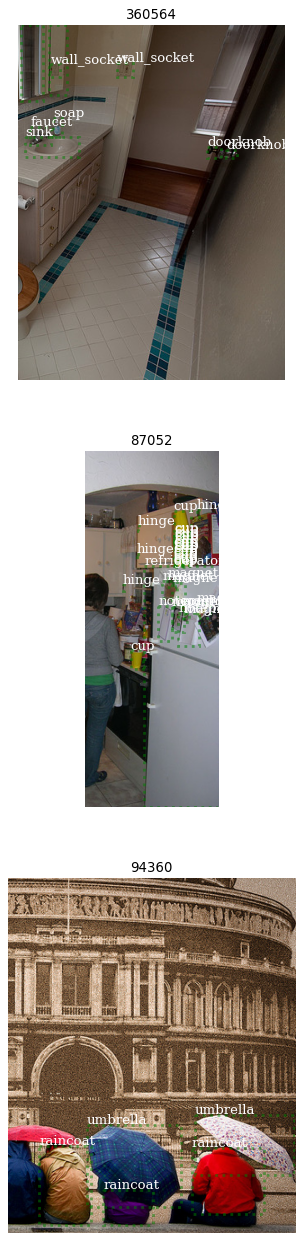

In [53]:
dataset.visualizeImages(side=Side.RIGHT, img_ids=[360564,87052,94360], save=True, imageName="right.jpg")

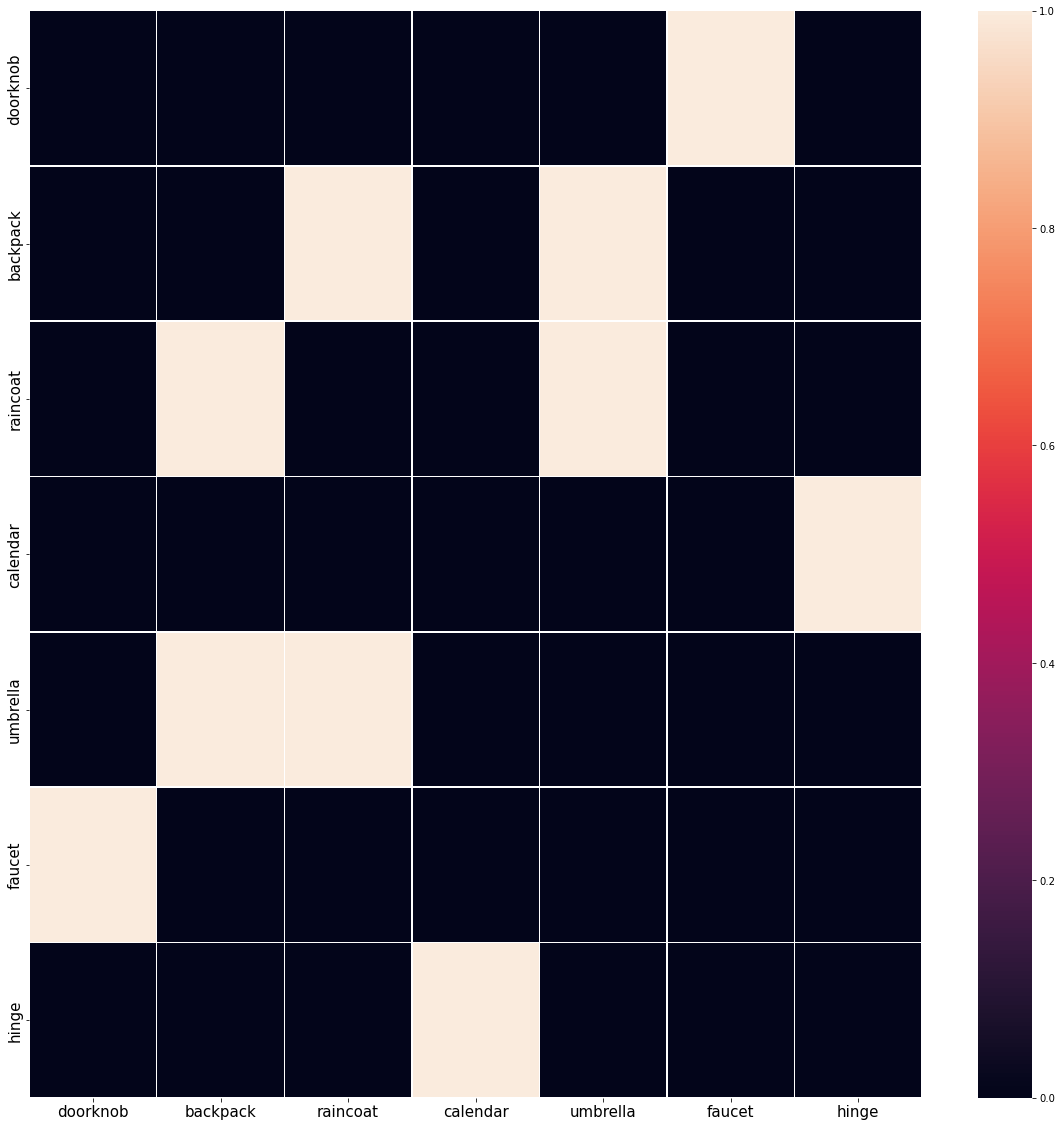

In [66]:
cats, matrix = dataset.getConcurrencyMatrix(img_type=ImageType.SYMMETRIC, img_ids=[360564,87052,94360])
cats_name = []
for _i in cats:
    cats_name.append(dataset.cats[_i]["name"])

import seaborn as sns
import numpy as np
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)
ax = sns.heatmap(matrix, linewidth=0.5)
ax.set_xticklabels(cats_name, fontsize=15)
ax.set_yticklabels(cats_name, fontsize=15)
plt.show()
fig.savefig('./save/images/symm.jpg')

In [ ]:
'''
Dataframe of categories
| id | image_count_ | synonyms | description | synset | name | frequency | instance_count |
'''
dataCats = pd.DataFrame(list(dataset.cats.values()) )
dataCats = dataCats.set_index('id')
dataCats.head()

In [ ]:
'''
Dataframe of categories with only required info
| id | name | synonyms | image_count | instance_count |
'''
catsDF = dataCats[['name', 'synonyms', 'image_count', 'instance_count' ]]
catsDF.head()

In [ ]:
'''
Dataframe of annotations
| id | area | segmentation | image_id | bbox | category_id |
'''
dataAnns = pd.DataFrame(list(dataset.anns.values()) ) 
dataAnns = dataAnns.set_index('id')
dataAnns.head()

In [ ]:
'''
Dataframe of annotations with only required info
| id | area | image_id | bbox | category_id |
'''
annsDF = dataAnns[['area', 'image_id', 'bbox', 'category_id', 'side']]
annsDF.head()

In [ ]:
'''
Dataframe of images
| id | date_captured | neg_category_ids | license | height | width | flickr_url | coco_url | not_exhaustive_category_ids |
'''
dataImgs = pd.DataFrame(list(dataset.imgs.values()) )
dataImgs = dataImgs.set_index('id')
dataImgs.head()

In [ ]:
'''
Dataframe of images with only required info
| id | height | width | coco_url | instance_count |
'''
tempDF = annsDF.groupby(["image_id"]).size().reset_index(name="count")
imgsDF = dataImgs[['height', 'width', 'coco_url']]
imgsDF['instance_count'] = 0
for i in tempDF.index:
    row = tempDF.loc[i]
    imgsDF.at[row.image_id, 'instance_count'] = row['count']
imgsDF.head()

In [ ]:
'''
Merge annsDF, imgsDF, catsDF to get height, width, cat_name
| id | category_id | image_id | bbox | height | width | cat_name |
'''
annsImgsDF = annsDF[['category_id', 'image_id', 'bbox', 'side' ]]
annsImgsDF[['height', 'width' ]] = annsImgsDF.image_id.progress_apply(lambda x : imgsDF.loc[x][['height', 'width']])
annsImgsDF['cat_name'] = annsImgsDF.category_id.progress_apply(lambda x : catsDF.loc[x]['name'])
annsImgsDF.head()

In [ ]:
'''
Category count on left and right
'''
tempDf = annsImgsDF.groupby(['category_id', 'side']).size().reset_index(name="count")
catsDF[['left_instance_count', 'right_instance_count', 'instance_not_include']] = 0
for i in tempDf.index:
    row = tempDf.loc[i]
    if row.side == Side.LEFT:
        catsDF.at[row.category_id, 'left_instance_count'] = row['count']
    elif row.side == Side.RIGHT:
        catsDF.at[row.category_id, 'right_instance_count'] = row['count']
    else:
        catsDF.at[row.category_id, 'instance_not_include'] = row['count']
catsDF.head()

In [ ]:
'''
Image count on left and right annotation
'''
tempDf = annsImgsDF.groupby(['image_id', 'side']).size().reset_index(name="count")
imgsDF[['left_instance_count', 'right_instance_count', 'instance_not_include']] = 0
for i in tempDf.index:
    row = tempDf.loc[i]
    if row.side == Side.LEFT:
        imgsDF.at[row.image_id, 'left_instance_count'] = row['count']
    elif row.side == Side.RIGHT:
        imgsDF.at[row.image_id, 'right_instance_count'] = row['count']
    else:
        imgsDF.at[row.image_id, 'instance_not_include'] = row['count']
imgsDF.head()

In [ ]:
'''
Full Image stats
'''
# Image count per category
print("===========================")
print("|Stats based on Categories|")
print("===========================")
print("")
print("Stats based on Image count:")
print("===========================")
print("Top {} Catogries:".format(10))
print(catsDF[['name', 'image_count']].nlargest(10, 'image_count'))
print("---------------------------")
print("Lowest {} Catogries:".format(10))
print(catsDF[['name', 'image_count']].nsmallest(10, 'image_count'))
print("---------------------------")
print("Describe:")
print(catsDF.image_count.describe().round(3))
print("===========================")
print("")
print("Stats based on instance count:")
print("===========================")
print("Top {} Catogries:".format(10))
print(catsDF[['name', 'instance_count']].nlargest(10, 'instance_count'))
print("---------------------------")
print("Lowest {} Catogries:".format(10))
print(catsDF[['name', 'instance_count']].nsmallest(10, 'instance_count'))
print("---------------------------")
print("Describe:")
print(catsDF.instance_count.describe().round(3))
print("===========================")
print("")
print("Non-Zero categories count: {} / {} ".format((catsDF.instance_count != 0).sum(), len(catsDF)) )
print("===========================")
print("")
print("Stats based on Left Image count:")
print("===========================")
print("Top {} Catogries:".format(10))
print(catsDF[['name', 'left_instance_count']].nlargest(10, 'left_instance_count'))
print("---------------------------")
print("Lowest {} Catogries:".format(10))
print(catsDF[['name', 'left_instance_count']].nsmallest(10, 'left_instance_count'))
print("---------------------------")
print("Describe:")
print(catsDF.left_instance_count.describe().round(3))
print("===========================")
print("")
print("Non-Zero categories count: {} / {} ".format((catsDF.left_instance_count != 0).sum(), len(catsDF)) )
print("===========================")
print("")
print("Stats based on Right Image count:")
print("===========================")
print("Top {} Catogries:".format(10))
print(catsDF[['name', 'right_instance_count']].nlargest(10, 'right_instance_count'))
print("---------------------------")
print("Lowest {} Catogries:".format(10))
print(catsDF[['name', 'right_instance_count']].nsmallest(10, 'right_instance_count'))
print("---------------------------")
print("Describe:")
print(catsDF.right_instance_count.describe().round(3))
print("===========================")
print("")
print("Non-Zero categories count: {} / {} ".format((catsDF.right_instance_count != 0).sum(), len(catsDF)) )
print("===========================")
print("")
print("===========================")
print("|  Stats based on Images  |")
print("===========================")
print("")
print("Stats based on instance count:")
print("===========================")
print("Top {} Catogries:".format(10))
print(imgsDF[['instance_count']].nlargest(10, 'instance_count'))
print("---------------------------")
print("Lowest {} Catogries:".format(10))
print(imgsDF[['instance_count']].nsmallest(10, 'instance_count'))
print("---------------------------")
print("Describe:")
print(imgsDF.instance_count.describe().round(3))
print("===========================")
print("")
print("Stats based on left instance count:")
print("===========================")
print("Top {} Catogries:".format(10))
print(imgsDF[['left_instance_count']].nlargest(10, 'left_instance_count'))
print("---------------------------")
print("Lowest {} Catogries:".format(10))
print(imgsDF[['left_instance_count']].nsmallest(10, 'left_instance_count'))
print("---------------------------")
print("Describe:")
print(imgsDF.instance_count.describe().round(3))
print("===========================")
print("")
print("Stats based on right instance count:")
print("===========================")
print("Top {} Catogries:".format(10))
print(imgsDF[['right_instance_count']].nlargest(10, 'right_instance_count'))
print("---------------------------")
print("Lowest {} Catogries:".format(10))
print(imgsDF[['right_instance_count']].nsmallest(10, 'right_instance_count'))
print("---------------------------")
print("Describe:")
print(imgsDF.right_instance_count.describe().round(3))
print("===========================")
print("")